In [15]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import the EBM classifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

# Set plot style
sns.set(style='whitegrid')

In [16]:
import pandas as pd

df1 = pd.read_csv('positive.csv', na_values=['NULL'])

df2 = pd.read_csv('negative.csv', na_values=['NULL'])

df = pd.concat([df1, df2], ignore_index=True)

df['AcquisitionDateTime_DT'] = pd.to_datetime(df['AcquisitionDateTime_DT'])

print(df.head())

print(df.info())
print(df.isnull().sum())

  PatientID                              12SL_Codes Source  \
0   HR00008       22,542,1665,533,1666,780,831,1699  PTBXL   
1   HR00077                         22,964,821,1699  PTBXL   
2   HR00085  22,542,1665,531,1666,1682,740,831,1699  PTBXL   
3   HR00103                     23,470,780,831,1699  PTBXL   
4   HR00128                    22,1682,780,831,1699  PTBXL   

                                          Phys_Codes  MI_12SL  MI_Phys  \
0          164865005, 164951009, 39732003, 426783006        1        1   
1                     426783006, 54329005, 713426002        1        1   
2                                          426783006        1        0   
3  164865005, 164951009, 39732003, 427084000, 445...        1        1   
4                                          164934002        1        0   

   TestID  PatientAge  Gender AcquisitionDateTime_DT  ...  STDOWN_V6  \
0       8         NaN     NaN    2020-04-23 07:59:54  ...          0   
1      77         NaN     NaN    2020-

In [17]:
from sklearn.model_selection import train_test_split
import pandas as pd

y = df["MI_Phys"]

analysis_codes_fn = ['HR00039', 'HR00162', 'HR00274', 'HR00282', 'HR00308']
analysis_codes_fp = ['HR00085', 'HR00128', 'HR00222', 'HR00265', 'HR00527', 'HR00529', 'HR00855', 'HR00994', 'HR00995', 'HR01026', 'HR01528', 'HR02158', 'HR04251', 'HR04274', 'HR04841', 'HR04986', 'HR04986', 'HR05233', 'HR06205', 'HR08265', 'HR10943', 'HR11886', 'JS00403', 'Q0012', 'Q0016']

df_fn_records = df[df['PatientID'].isin(analysis_codes_fn)]
df_fp_records = df[df['PatientID'].isin(analysis_codes_fp)]

df_fn_records_clean = df_fn_records.drop(columns=["12SL_Codes", "MI_12SL","Phys_Codes", "TestID", "Source",
                                                  "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys", "POffset", "PAxis", "POnset"])
df_fp_records_clean = df_fp_records.drop(columns=["12SL_Codes", "MI_12SL","Phys_Codes", "TestID", "Source",
                                                  "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys", "POffset", "PAxis", "POnset"])

X = df.drop(columns=["PatientID", "12SL_Codes", "Phys_Codes", "TestID", "Source", 
                     "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys", "POffset", "PAxis", "POnset"])

#drop columns that include "P_", "Full", "Rate"

X = X.loc[:, ~X.columns.str.contains('P_')]
X = X.loc[:, ~X.columns.str.contains('Full')]
X = X.loc[:, ~X.columns.str.contains('Rate')]

df_fn_records_clean = df_fn_records_clean.loc[:, ~df_fn_records_clean.columns.str.contains('P_')]
df_fn_records_clean = df_fn_records_clean.loc[:, ~df_fn_records_clean.columns.str.contains('Full')]
df_fn_records_clean = df_fn_records_clean.loc[:, ~df_fn_records_clean.columns.str.contains('Rate')]

df_fp_records_clean = df_fp_records_clean.loc[:, ~df_fp_records_clean.columns.str.contains('P_')]
df_fp_records_clean = df_fp_records_clean.loc[:, ~df_fp_records_clean.columns.str.contains('Full')]
df_fp_records_clean = df_fp_records_clean.loc[:, ~df_fp_records_clean.columns.str.contains('Rate')]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Save the original algorithm's prediction for test set before dropping it
y_12SL = X_test["MI_12SL"]

# Split data based on MI_12SL classification
X_train_pos = X_train[X_train["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_train_neg = X_train[X_train["MI_12SL"] == 0].drop(columns=["MI_12SL"])
X_test_pos = X_test[X_test["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_test_neg = X_test[X_test["MI_12SL"] == 0].drop(columns=["MI_12SL"])

# Ensure y labels match the correct samples
y_train_pos = y_train.loc[X_train_pos.index]  # True positives or false positives
y_train_neg = y_train.loc[X_train_neg.index]  # True negatives or false negatives
y_test_pos = y_test.loc[X_test_pos.index]
y_test_neg = y_test.loc[X_test_neg.index]

X_train = X_train.drop(columns=["MI_12SL"])
X_test = X_test.drop(columns=["MI_12SL"])

# Extract MI_12SL predictions
y_12SL_pos = y_12SL.loc[X_test_pos.index]  # Original classifier's labels
y_12SL_neg = y_12SL.loc[X_test_neg.index]


In [18]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy='constant', fill_value=-1000)
# X_train_pos = imputer.fit_transform(X_train_pos)
# X_test_pos = imputer.transform(X_test_pos)
# X_train_neg = imputer.fit_transform(X_train_neg)
# X_test_neg = imputer.transform(X_test_neg)

In [19]:
ebm = ExplainableBoostingClassifier(
    learning_rate=0.2,
    max_bins=255,
    interactions=2,
    min_samples_leaf=10,
    n_jobs=-2
)
ebm.fit(X_train_pos, y_train_pos)

# Make predictions
y_pred_pos = ebm.predict(X_test_pos)
print("Accuracy:", accuracy_score(y_test_pos, y_pred_pos))
# F1 score
from sklearn.metrics import f1_score
print("F1 Score:", f1_score(y_test_pos, y_pred_pos))

# Show feature importance
show(ebm.explain_global())

Accuracy: 0.7790636507101526
F1 Score: 0.7338403041825095


<!-- http://127.0.0.1:7001/2279966484448/ -->

In [20]:
import optuna
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np

def objective(trial):
    # Define the search space
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_bins = trial.suggest_int("max_bins", 64, 512)
    interactions = trial.suggest_int("interactions", 0, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 100)
    max_leaves = trial.suggest_int("max_leaves", 2, 64)
    
    ebm = ExplainableBoostingClassifier(
        learning_rate=learning_rate,
        max_bins=max_bins,
        interactions=interactions,
        min_samples_leaf=min_samples_leaf,
        max_leaves=max_leaves,
        n_jobs=-2
    )
    
    ebm.fit(X_train_pos, y_train_pos)
    y_pred = ebm.predict(X_test_pos)

    return f1_score(y_test_pos, y_pred)

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Best F1 score:", study.best_value)


[I 2025-04-11 22:21:05,826] A new study created in memory with name: no-name-6302f6c9-4705-4bbe-8bf5-528e49a1614d
[I 2025-04-11 22:21:36,137] Trial 0 finished with value: 0.7172503242542153 and parameters: {'learning_rate': 0.20752254491146846, 'max_bins': 137, 'interactions': 5, 'min_samples_leaf': 26, 'max_leaves': 27}. Best is trial 0 with value: 0.7172503242542153.
[I 2025-04-11 22:21:56,575] Trial 1 finished with value: 0.69433465085639 and parameters: {'learning_rate': 0.017622306234499167, 'max_bins': 426, 'interactions': 3, 'min_samples_leaf': 58, 'max_leaves': 50}. Best is trial 0 with value: 0.7172503242542153.
[I 2025-04-11 22:22:02,300] Trial 2 finished with value: 0.7338864071474155 and parameters: {'learning_rate': 0.010085239560083906, 'max_bins': 118, 'interactions': 0, 'min_samples_leaf': 76, 'max_leaves': 3}. Best is trial 2 with value: 0.7338864071474155.
[I 2025-04-11 22:22:08,534] Trial 3 finished with value: 0.7125081859855926 and parameters: {'learning_rate': 0.0

Best parameters: {'learning_rate': 0.017598484130880703, 'max_bins': 141, 'interactions': 5, 'min_samples_leaf': 15, 'max_leaves': 4}
Best F1 score: 0.7560050568900126


In [21]:
best_ebm = ExplainableBoostingClassifier(
    **study.best_params,
    n_jobs=-2
)
best_ebm.fit(X_train_pos, y_train_pos)

from sklearn.metrics import classification_report
print(classification_report(y_test_pos, best_ebm.predict(X_test_pos)))


              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1108
           1       0.76      0.75      0.76       793

    accuracy                           0.80      1901
   macro avg       0.79      0.79      0.79      1901
weighted avg       0.80      0.80      0.80      1901



## Model Evaluation

Test Accuracy: 0.7790636507101526
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1108
           1       0.74      0.73      0.73       793

    accuracy                           0.78      1901
   macro avg       0.77      0.77      0.77      1901
weighted avg       0.78      0.78      0.78      1901



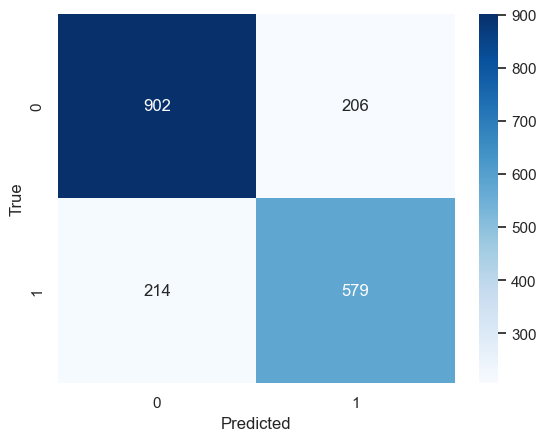

In [22]:
# Make predictions on the test set
y_pred = ebm.predict(X_test_pos)

# Evaluate accuracy
accuracy = accuracy_score(y_test_pos, y_pred)
print('Test Accuracy:', accuracy)

# Display classification report
print(classification_report(y_test_pos, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test_pos, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
# Global explanation
global_explanation = ebm.explain_global()
show(global_explanation)

# Local explanation for the first 5 instances
local_explanation = ebm.explain_local(X_test_pos.iloc[:5], y_test_pos.iloc[:5])
show(local_explanation)

<!-- http://127.0.0.1:7001/2280335840304/ -->

<!-- http://127.0.0.1:7001/2280615231808/ -->

In [24]:
ebm = ExplainableBoostingClassifier(
    learning_rate=0.001,
    max_bins=512,
    interactions=100,
    min_samples_leaf=100,
    early_stopping_rounds=50,
    n_jobs=-2, 
    random_state=42
)

from sklearn.utils.class_weight import compute_sample_weight

# Compute weights based on class distribution
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_neg)

# Train EBM with sample weights
ebm.fit(X_train_neg, y_train_neg, sample_weight=sample_weights)

#ebm.fit(X_train_neg, y_train_neg)

# Make predictions
y_pred_neg = ebm.predict(X_test_neg)
print("Accuracy:", accuracy_score(y_test_neg, y_pred_neg))
# F1 score
from sklearn.metrics import f1_score
print("F1 Score:", f1_score(y_test_neg, y_pred_neg))

# Show feature importance
show(ebm.explain_global())

Accuracy: 0.8557103885571039
F1 Score: 0.40643008795875035


<!-- http://127.0.0.1:7001/2279972549888/ -->

In [25]:
import optuna
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np

def objective(trial):
    # Define the search space
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_bins = trial.suggest_int("max_bins", 64, 512)
    interactions = trial.suggest_int("interactions", 0, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 100)
    max_leaves = trial.suggest_int("max_leaves", 2, 64)
    
    ebm = ExplainableBoostingClassifier(
        learning_rate=learning_rate,
        max_bins=max_bins,
        interactions=interactions,
        min_samples_leaf=min_samples_leaf,
        max_leaves=max_leaves,
        n_jobs=-2
    )
    
    ebm.fit(X_train_neg, y_train_neg)
    y_pred = ebm.predict(X_test_neg)

    return f1_score(y_test_neg, y_pred)

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Best F1 score:", study.best_value)


[I 2025-04-11 22:56:34,354] A new study created in memory with name: no-name-ddad4d32-38a2-42f6-bfd8-e2701f523df0
[I 2025-04-11 22:56:49,919] Trial 0 finished with value: 0.36632747456059206 and parameters: {'learning_rate': 0.16705867126133353, 'max_bins': 371, 'interactions': 0, 'min_samples_leaf': 13, 'max_leaves': 21}. Best is trial 0 with value: 0.36632747456059206.
[I 2025-04-11 22:57:35,299] Trial 1 finished with value: 0.32122370936902483 and parameters: {'learning_rate': 0.03889023241511361, 'max_bins': 449, 'interactions': 1, 'min_samples_leaf': 41, 'max_leaves': 39}. Best is trial 0 with value: 0.36632747456059206.
[I 2025-04-11 22:58:21,284] Trial 2 finished with value: 0.35940409683426444 and parameters: {'learning_rate': 0.040165378975088185, 'max_bins': 469, 'interactions': 5, 'min_samples_leaf': 65, 'max_leaves': 22}. Best is trial 0 with value: 0.36632747456059206.
[I 2025-04-11 22:59:06,076] Trial 3 finished with value: 0.39749328558639213 and parameters: {'learning_r

Best parameters: {'learning_rate': 0.2955572090603533, 'max_bins': 85, 'interactions': 1, 'min_samples_leaf': 19, 'max_leaves': 3}
Best F1 score: 0.4263157894736842


In [26]:
best_ebm = ExplainableBoostingClassifier(
    **study.best_params,
    inner_bags=20,
    n_jobs=-2
)
best_ebm.fit(X_train_neg, y_train_neg)

from sklearn.metrics import classification_report
print(classification_report(y_test_neg, best_ebm.predict(X_test_neg)))


              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12762
           1       0.72      0.29      0.41       801

    accuracy                           0.95     13563
   macro avg       0.84      0.64      0.69     13563
weighted avg       0.94      0.95      0.94     13563



Test Accuracy: 0.8557103885571039
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     12762
           1       0.27      0.84      0.41       801

    accuracy                           0.86     13563
   macro avg       0.63      0.85      0.66     13563
weighted avg       0.95      0.86      0.89     13563



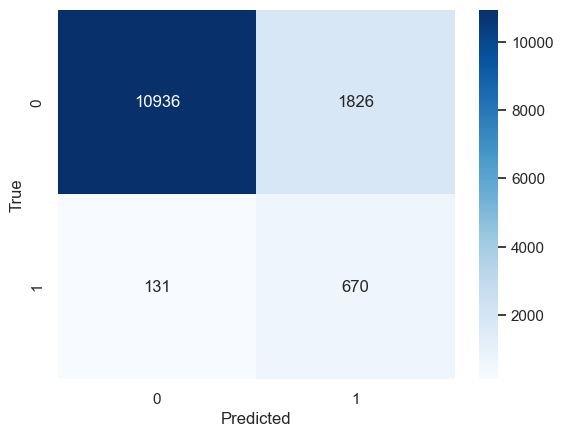

In [27]:
y_pred = ebm.predict(X_test_neg)

accuracy = accuracy_score(y_test_neg, y_pred)
print('Test Accuracy:', accuracy)

print(classification_report(y_test_neg, y_pred))

cm = confusion_matrix(y_test_neg, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
# Global explanation
global_explanation = ebm.explain_global()
show(global_explanation)

# Local explanation for the first 5 instances
local_explanation = ebm.explain_local(X_test_neg.iloc[:5], y_test_neg.iloc[:5])
show(local_explanation)

<!-- http://127.0.0.1:7001/2279969871904/ -->

<!-- http://127.0.0.1:7001/2280335846304/ -->